# Alpha Particle Cloud Chamber Trace Identifier Based on Convolutional Neural Network

This project proposes a Convolutional Neural Network (CNN) to recognise traces left by alpha particles in cloud chambers.

This notebook allows the user to run the code in a notebook instead of directly invoking the Python scripts (useful if for example the user does not have access to GPU-equipped devices and/or prefers using Google Colab resources). The code below is the very same of the Python scripts available on the repository (but for just minor specificities of the notebook environment, e.g. the dataset imports and the ```sys.argv``` command line inputs being replaced here by simple strings able to be edited on the fly by the user).

To import the dataset you may:
- upload the zip file to your Google Drive space and then mount the Drive storage onto this notebook environment (by clicking on the folder icon on the left sidebar and then, in the menu that appears, on the folder icon with the Drive logo). The zip file stays available also after closing the notebook, until you delete it from your Drive;
- upload it only on this session storage space, by clicking on the folder icon on the left sidebar and then, in the menu that appears, on the icon with a sheet and an arrow. The zip file only stays available for this Colab session and is deleted afterwards.

For a detailed description of the CNN and its approach please refer to the README of the repository.

## Dataset Import

In [ ]:
#This line runs as it is if you have uploaded the dataset zip file to your Google Drive space
#and you have mounted it as described above.
#If you are using the session-specific storage change the path accordingly.
!unzip -q /content/drive/MyDrive/cloud_chamber_dataset.zip

In [ ]:
#change the path accordingly if you are using the session-specific storage
!ls /content/cloud_chamber_dataset

test  train  valid


## Training

The code below is the replica of the one inside script ```training.py```.

In [ ]:
import os
import sys
import json
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout, RandomFlip, RandomRotation, RandomTranslation
from keras.preprocessing import image
from keras.metrics import Precision, Recall
import matplotlib.pyplot as plt

In [ ]:
#definition of folders with training and validation samples
#change the dataDir path accordingly if you are using the session-specific storage
dataDir = "/content/cloud_chamber_dataset"
trainDir = os.path.join(dataDir, "train")
validDir = os.path.join(dataDir, "valid")
print("dataDir:", dataDir)

dataDir: /content/cloud_chamber_dataset


In [ ]:
#pixel rescaling from [0, 255] to [0, 1]
trainImageDataGenerator = image.ImageDataGenerator(rescale=1./255)
validImageDataGenerator = image.ImageDataGenerator(rescale=1./255)

In [ ]:
#generators
trainGenerator = trainImageDataGenerator.flow_from_directory(trainDir, target_size=(768, 432), color_mode="grayscale", batch_size=30, class_mode="binary")
trainClassIndices = trainGenerator.class_indices #checks that signal class has index 1 as metrics Precision and Recall refer by default to the class with index 1
print("trainClassIndices:", trainClassIndices)
validGenerator = validImageDataGenerator.flow_from_directory(validDir, target_size=(768, 432), color_mode="grayscale", batch_size=30, class_mode="binary")
validClassIndices = validGenerator.class_indices
print("validClassIndices:", validClassIndices)

Found 5284 images belonging to 2 classes.
trainClassIndices: {'background': 0, 'signal': 1}
Found 1751 images belonging to 2 classes.
validClassIndices: {'background': 0, 'signal': 1}


In [ ]:
#data augmentation, as the dataset is still too small for proper training
dataAugmentation = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomTranslation(0.3, 0.3),
  RandomRotation(0.3),
])

In [ ]:
#model definition
model = Sequential()
model.add(dataAugmentation)
model.add(Conv2D(16, (3, 3), activation="relu", padding="same", name="conv_1", input_shape=(768, 432, 1)))
model.add(MaxPooling2D((3, 3), name="maxpool_1"))
model.add(Conv2D(16, (3, 3), activation="relu", padding="same", name="conv_2"))
model.add(MaxPooling2D((3, 3), name="maxpool_2"))
model.add(Conv2D(16, (3, 3), activation="relu", padding="same", name="conv_3"))
model.add(MaxPooling2D((3, 3), name="maxpool_3"))
model.add(Conv2D(16, (3, 3), activation="relu", padding="same", name="conv_4"))
model.add(MaxPooling2D((3, 3), name="maxpool_4"))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu", name="dense_1"))
model.add(Dense(32, activation="relu", name="dense_2"))
model.add(Dense(1, activation="sigmoid", name="output"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[Precision(), Recall()])

In [ ]:
#training
history = model.fit(trainGenerator, steps_per_epoch=150, epochs=20, validation_data=validGenerator, validation_steps=50, verbose=1)


Epoch 1/20
150/150 [==============================] - 70s 405ms/step - loss: 0.3166 - precision: 0.1333 - recall: 0.0055 - val_loss: 0.2834 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
150/150 [==============================] - 52s 350ms/step - loss: 0.2789 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2061 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
150/150 [==============================] - 52s 345ms/step - loss: 0.1863 - precision: 0.8827 - recall: 0.3972 - val_loss: 0.1057 - val_precision: 0.8906 - val_recall: 0.5182
Epoch 4/20
150/150 [==============================] - 51s 342ms/step - loss: 0.1679 - precision: 0.8683 - recall: 0.5000 - val_loss: 0.1076 - val_precision: 0.9221 - val_recall: 0.6396
Epoch 5/20
150/150 [==============================] - 51s 337ms/step - loss: 0.1659 - precision: 0.8853 - recall: 0.5452 - val_loss: 0.0892 - val_precision: 0.8889 - val_recall: 0.6792
Epoch 6/20
150/150 [==============================]

In [ ]:
#model saving
model.save("/content/drive/MyDrive/savedModel/model")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, None   0         
                             )                                   
                                                                 
 conv_1 (Conv2D)             (None, None, None, 16)    160       
                                                                 
 maxpool_1 (MaxPooling2D)    (None, None, None, 16)    0         
                                                                 
 conv_2 (Conv2D)             (None, None, None, 16)    2320      
                                                                 
 maxpool_2 (MaxPooling2D)    (None, None, None, 16)    0         
                                                                 
 conv_3 (Conv2D)             (None, None, None, 16)    2320      
                                                      

In [ ]:
#saving history to file
historyDict = history.history
with open("/content/drive/MyDrive/historyDict.json", "w") as historyDictFile:
  json.dump(historyDict, historyDictFile)

## Plotting

The code below is the replica of the one inside script ```plotting.py```.

In [ ]:
#load training performance metrics from json file
historyDictFilePath = "/content/drive/MyDrive/historyDict.json"
with open(historyDictFilePath, "r") as historyDictFile:
  historyDict = json.load(historyDictFile)

In [ ]:
#plotting
epochs = 20
epochRange = range(1,epochs+1)

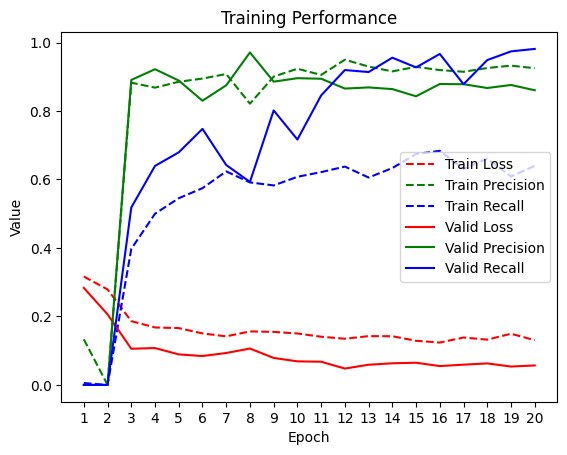

In [ ]:
historyTrainLoss = historyDict["loss"]
historyTrainPrecision = historyDict["precision"]
historyTrainRecall = historyDict["recall"]
historyValidLoss = historyDict["val_loss"]
historyValidPrecision = historyDict["val_precision"]
historyValidRecall = historyDict["val_recall"]

plt.plot(epochRange, historyTrainLoss, color="r", label="Train Loss", linestyle="--")
plt.plot(epochRange, historyTrainPrecision, color="g", label="Train Precision", linestyle="--")
plt.plot(epochRange, historyTrainRecall, color="b", label="Train Recall", linestyle="--")
plt.plot(epochRange, historyValidLoss, color="r", label="Valid Loss")
plt.plot(epochRange, historyValidPrecision, color="g", label="Valid Precision")
plt.plot(epochRange, historyValidRecall, color="b", label="Valid Recall")

plt.xlabel("Epoch")
plt.xticks(epochRange)
plt.ylabel("Value")
plt.title("Training Performance")
plt.legend()
plt.show()